# Distilling DQNs

In [1]:
import numpy as np
import graphviz
import pandas as pd
from sklearn import linear_model, tree
import gym
import random
from gym import wrappers
import tensorflow as tf
from matplotlib import pyplot as plt
#import pandas as pdd
#import ray.dataframe as pd
plt.style.use('ggplot')
from matplotlib import rcParams
rcParams['figure.figsize'] = 35, 15
import pickle
import csv

In [2]:
def smoothListGaussian(list, degree=20):
    window = degree * 2 - 1
    weight = np.array([1.0] * window)
    weightGauss = []

    for i in range(window):
        i = i - degree + 1
        frac = i / float(window)
        gauss = 1 / (np.exp((4.0 * (frac)) ** 2.0))
        weightGauss.append(gauss)

    weight = np.array(weightGauss) * weight
    smoothed = [0.0] * (len(list) - window)

    for i in range(len(smoothed)):
        smoothed[i] = sum(np.array(list[i:i + window]) * weight) / sum(weight)

    return smoothed


def plotster(arr):
    # arr = smoothListGaussian(arr)
    arr = sum(arr, [])
    x = np.linspace(0, len(arr), len(arr))
    # pd.DataFrame(data = arr[0:, 0:], index = x, columns = np.asarray([0, 1]))

    fig, ax = plt.subplots()
    # m, b = np.polyfit(x, arr, 1)
    # print "learning slope: ", m
    ax.plot(arr)
    # ax.plot(x, m*x + b, '-')
    plt.show()

def medfilt (x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:, i] = x[:-j]
        y[:j, i] = x[0]
        y[:-j, -(i+1)] = x[j:]
        y[-j:, -(i+1)] = x[-1]
    return np.median (y, axis=1)

def findMax(arr):
    arr = sum(arr, []) #makes single list out of list of lists by merging
    n = len(arr)
    k = 100
    if k > n:
      print "need more episodes"
      return -1
    else:
      sums = np.sum(arr)
      max_sum = sum
      max_end = k-1

      for i in xrange(k, n-1):
        sums += arr[i] - arr[i-k]
        if sums > max_sum:
          max_sum = sums
          max_end = i

    #return 1/(np.mean(arr[max_end - k + 1 : max_end + 1]))
    #print "TopScore", (np.mean(arr[max_end - k + 1 : max_end + 1]))

In [3]:
class DQN:
    REPLAY_MEMORY_SIZE = 100000000
    RANDOM_ACTION_DECAY = 0.9999 #0.9999
    MIN_RANDOM_ACTION_PROB = 0.1 #0.1
    HIDDEN1_SIZE = 32  # 32
    HIDDEN2_SIZE = 64  # 64
    HIDDEN3_SIZE = 512  # 512
    MAX_STEPS = 5000000
    LEARNING_RATE = 0.00025 #0.00025
    MINIBATCH_SIZE = 32
    DISCOUNT_FACTOR = 0.99
    TARGET_UPDATE_FREQ = 4
    LOG_DIR = '/tmp/dqn'
    random_action_prob = 1
    replay_memory = []
    experiment_filename = './cartpole-experiment-1'
    freqMult = 1
    returns = []
    total_steps = 0
    step_counts = []
    norm_step = []
    norm_return = []
    NUM_EPISODES = 500

    def __init__(self, env):
        self.env = gym.make(env)
        #self.render = lambda : plt.imshow(self.env.render(mode='rgb_array'))
        assert len(self.env.observation_space.shape) == 1
        self.input_size = self.env.observation_space.shape[0]
        self.output_size = self.env.action_space.n

    def init_network(self):
        # Inference
        self.x = tf.placeholder(tf.float32, [None, self.input_size])

        with tf.name_scope('hidden1'):
            W1 = tf.Variable(tf.truncated_normal([self.input_size, self.HIDDEN1_SIZE], stddev=0.01), name='W1')
            b1 = tf.Variable(tf.zeros(self.HIDDEN1_SIZE), name='b1')
            h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)

        with tf.name_scope('hidden2'):
            W2 = tf.Variable(tf.truncated_normal([self.HIDDEN1_SIZE, self.HIDDEN2_SIZE], stddev=0.01), name='W2')
            b2 = tf.Variable(tf.zeros(self.HIDDEN2_SIZE), name='b2')
            h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
            
        with tf.name_scope('hidden3'):
            W3 = tf.Variable(tf.truncated_normal([self.HIDDEN2_SIZE, self.HIDDEN3_SIZE], stddev=0.01), name='W3')
            b3 = tf.Variable(tf.zeros(self.HIDDEN3_SIZE), name='b2')
            h3 = tf.nn.relu(tf.matmul(h2, W3) + b3)

        with tf.name_scope('output'):
            W4 = tf.Variable(tf.truncated_normal([self.HIDDEN3_SIZE, self.output_size], stddev=0.01), name='W4')
            b4 = tf.Variable(tf.zeros(self.output_size), name='b3')
            self.Q = tf.matmul(h3, W4) + b4
        self.weights = [W1, b1, W2, b2, W3, b3, W4, b4]

        # Defining Loss
        self.targetQ = tf.placeholder(tf.float32, [None])
        self.targetActionMask = tf.placeholder(tf.float32, [None, self.output_size])
        q_values = tf.reduce_sum(tf.multiply(self.Q, self.targetActionMask), reduction_indices=[1])
        #temploss = tf.add(tf.subtract(q_values, self.targetQ), self.eta * tf.subtract(q_values, tf.reduce_max(q_values, axis=0)))
        temploss = tf.subtract(q_values, self.targetQ)
        self.loss = tf.reduce_mean(tf.square(temploss))

        # Regularization
        # for w in [W1, W2, W3]:
        #  self.loss += self.FACTOR * tf.reduce_sum(tf.square(w))

        # Training
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        self.train_op = optimizer.minimize(self.loss, global_step=global_step)
        

    def train(self, num_episodes=NUM_EPISODES):
        self.session = tf.Session()
        # Summary for TensorBoard
        tf.summary.scalar('loss', self.loss)
        self.summary = tf.summary.merge_all()
        self.summary_writer = tf.summary.FileWriter(logdir=self.LOG_DIR, graph=self.session.graph)
        self.session.run(tf.global_variables_initializer())

        target_weights = self.session.run(self.weights)

        for episode in range(num_episodes):
            state = self.env.reset()
            #self.render()
            steps = 0
            episodic_return = 0

            for step in range(self.MAX_STEPS):
                action = None
                if random.random() < self.random_action_prob:
                    action = self.env.action_space.sample()
                else:
                    q_values = self.session.run(self.Q, feed_dict={self.x: [state]})
                    action = q_values.argmax()
                self.update_random_action_prob()
                obs, reward, done, _ = self.env.step(action)
                episodic_return += reward

                # Update replay memory
                if done:
                    reward = -20
                self.replay_memory.append((state, action, reward, obs, done))
                if len(self.replay_memory) > self.REPLAY_MEMORY_SIZE:
                    self.replay_memory.pop(0)

                state = obs

                # Sample a random minibatch and fetch max Q at s'
                if len(self.replay_memory) >= self.MINIBATCH_SIZE:
                    minibatch = random.sample(self.replay_memory, self.MINIBATCH_SIZE)
                    next_states = [m[3] for m in minibatch]

                    feed_dict = {self.x: next_states}
                    feed_dict.update(zip(self.weights, target_weights))
                    q_values = self.session.run(self.Q, feed_dict=feed_dict)
                    max_q_values = q_values.max(axis=1)

                    # Compute target Q values
                    target_q = np.zeros(self.MINIBATCH_SIZE)
                    target_action_mask = np.zeros((self.MINIBATCH_SIZE, self.output_size), dtype=int)

                    # Update here to change targets
                    for i in range(self.MINIBATCH_SIZE):
                        _, action, reward, _, terminal = minibatch[i]
                        target_q[i] = reward
                        if not terminal:
                            target_q[i] += self.DISCOUNT_FACTOR * max_q_values[i]
                        target_action_mask[i][action] = 1

                    # Gradient descent
                    states = [m[0] for m in minibatch]
                    feed_dict = {
                        self.x: states,
                        self.targetQ: target_q,
                        self.targetActionMask: target_action_mask,
                    }
                    _, summary = self.session.run([self.train_op, self.summary], feed_dict=feed_dict)

                    # Write summary for TensorBoard
                    if self.total_steps % 100 == 0:
                        self.summary_writer.add_summary(summary, self.total_steps)

                self.total_steps += 1
                steps += 1
                if done:
                    episodic_return += reward
                    self.returns.append(episodic_return)
                    break

            self.step_counts.append(steps)
            # mean_steps = np.mean(step_counts[-100:])
            # print("Training episode = {}, Total steps = {}, Last-100 mean steps = {}".format(episode, total_steps, mean_steps))

            # Update target network
            if episode % self.TARGET_UPDATE_FREQ == 0:
                target_weights = self.session.run(self.weights)
        
        # Save trained model to my_trained_model 
#         modelName = "my_trained_model"
#         tf.train.Saver().save(self.session, './'+modelName) 
        #tf.train.Saver().save(self.session, 'my_trained_model')

        self.norm_step = [self.step_counts]  # [i/( self.freqMult) for i in self.step_counts] # Normalization
        self.norm_return = [self.returns]  # [i/(self.freqMult) for i in self.returns] # Normalization
        #print("max steps : {temp}".format(temp=findMax(self.norm_step)))
        #print("mean steps : {temp}".format(temp=np.mean(self.norm_step))) 
        #print("max returns : {temp}".format(temp=findMax(self.norm_return)))
        print("mean returns : {temp}".format(temp=np.mean(self.norm_return))) 
        #plotster(self.norm_step)
        plotster(self.norm_return)

    def update_random_action_prob(self):
        self.random_action_prob *= self.RANDOM_ACTION_DECAY
        if self.random_action_prob < self.MIN_RANDOM_ACTION_PROB:
            self.random_action_prob = self.MIN_RANDOM_ACTION_PROB

    def play(self):
        replay_buffer = []
        returns_list = []
        for episodes in range(200):
            state = self.env.reset()
            done = False
            steps = 0
            returns = 0
            q_values = self.session.run(self.Q, feed_dict={self.x: [state]})
            
            while not done and steps < 50000:
                #self.env.render(mode='rgb_array')
                action = q_values.argmax()
                state, rew, done, _ = self.env.step(action)
                steps += 1
                returns += rew
                q_values = self.session.run(self.Q, feed_dict={self.x: [state]})
                # Adding to replay buffer to train soft decision tree
                replay_buffer.append((q_values, state))
            returns_list.append(returns)    
        return steps, returns_list, replay_buffer

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
mean returns : 154.11


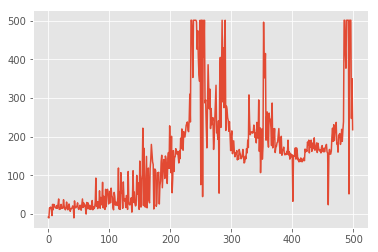

In [4]:
# ENV_LIST = ['CartPole-v1', 'Acrobot-v1', 'MountainCar-v0', 'MountainCarContinuous-v0','Pendulum-v0',
        # 'InvertedPendulum-v1', 'InvertedDoublePendulum-v1', 'Reacher-v1', 'HalfCheetah-v1', 'Swimmer-v1', '
        # Hopper-v1','Walker2d-v1', 'Ant-v1'. 'Humanoid-v1','HumanoidStandup-v1']
ENV_NAME = 'CartPole-v1'
dqn = DQN(ENV_NAME)
trial = []
trial_steps = []
dqn.init_network()
nb_trials = 1
for trialNum in range(0, nb_trials):
    dqn.train()
    dqn.env.close()

## Stop learning, start playing

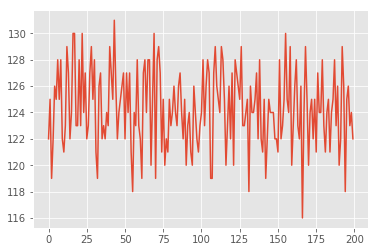

124.325

In [5]:
steps, returns, replay_buffer = dqn.play()
file_Name = "replay_buffer"

for i in range(np.shape(replay_buffer)[0]):
    replay_buffer[i] = np.concatenate([replay_buffer[i][0].flatten(), replay_buffer[i][1]], axis=0)
steps, returns, replay_buffer = dqn.play()
file_Name = "replay_buffer"

for i in range(np.shape(replay_buffer)[0]):
    replay_buffer[i] = np.concatenate([replay_buffer[i][0].flatten(), replay_buffer[i][1]], axis=0)

    
# Plot performance
x = np.linspace(0, len(returns), len(returns))
# pd.DataFrame(data = arr[0:, 0:], index = x, columns = np.asarray([0, 1]))

fig, ax = plt.subplots()
# m, b = np.polyfit(x, arr, 1)
# print "learning slope: ", m
ax.plot(returns)
# ax.plot(x, m*x + b, '-')
plt.show()

np.mean(returns)

In [6]:
# ### Save file to pickle and csv
# fileObject = open(file_Name,'wb') 

# # # this writes the object a to the file
# pickle.dump(replay_buffer,fileObject)   
# fileObject.close()
# fileObject = open("replay_buffer",'rb')
# # # load the object from the file into var
# buffer = pickle.load(fileObject)
# fileObject.close()

# with open("buffer.csv", "wb") as f:
#     writer = csv.writer(f)
#     writer.writerows(buffer)

In [7]:
s1,s2,s3,s4,q1,q2, addit = [],[],[],[],[],[],[]

for i in range(0, np.shape(replay_buffer)[0]):
    q1.append(replay_buffer[i][0])
    q2.append(replay_buffer[i][1])
    s1.append(replay_buffer[i][2])
    s2.append(replay_buffer[i][3])
    s3.append(replay_buffer[i][4])
    s4.append(replay_buffer[i][5])
    

## Creating new buffer dataframe with single output
# action_buffer = pd.DataFrame(data={'s1': s1,'s2': s2,'s3': s3,'s4': s4, 'actions':addit})

value_buffer = pd.DataFrame(data={'s1': s1,'s2': s2,'s3': s3,'s4': s4, 'Q1':q1, 'Q2': q2})
value_buffer.head()

Q1         Q2        s1        s2        s3        s4
0  87.776108  85.738327 -0.032115 -0.166163  0.019272  0.289653
1  87.601639  85.897629 -0.035439 -0.361555  0.025065  0.588352
2  86.750870  86.356354 -0.042670 -0.557018  0.036832  0.888824
3  68.550217  87.532761 -0.053810 -0.752620  0.054609  1.192854
4  75.058563  87.398880 -0.068863 -0.558247  0.078466  0.917775

In [8]:
# Play function for simpler models

def newmodel_play(reg_val1, reg_val2=None):
    #replay_buffer = []
    returns_list = []
    env = gym.make('CartPole-v1')
    for episodes in range(200):
        state = env.reset()
        done = False
        steps = 0
        returns = 0
        while not done and steps < 50000:
            #self.env.render(mode='rgb_array')
            #action = reg.predict(state.reshape(1, -1))
            action = np.argmax(reg_val1.predict(state.reshape(1, -1))) if reg_val2==None else np.argmax([reg_val1.predict(state.reshape(1, -1)), reg_val2.predict(state.reshape(1, -1))])
            #action = random.randint(0,1)
            state, rew, done, _ = env.step(action)
            steps += 1
            returns += rew
            #q_values = self.session.run(self.Q, feed_dict={self.x: [state]})
            # Adding to replay buffer to train soft decision tree
            #replay_buffer.append((q_values, state))
        returns_list.append(returns)    
    return returns_list


# Plot performance of new models
def plotter(returns):
    # Plotting performance
    x = np.linspace(0, len(returns), len(returns)) 
    fig, ax = plt.subplots()
    # m, b = np.polyfit(x, arr, 1)
    # print "learning slope: ", m
    ax.plot(returns)
    # ax.plot(x, m*x + b, '-')
    plt.show()

### Linear Regression

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
162.755


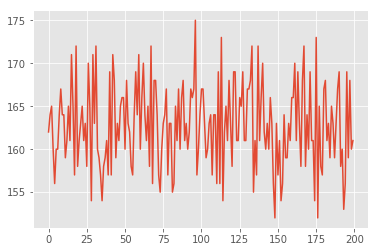

In [9]:
# reg = linear_model.LinearRegression()
# reg.fit (action_buffer[['s1', 's2','s3','s4']], action_buffer['actions'])

reg_val1 = linear_model.LinearRegression()
reg_val1.fit (value_buffer[['s1', 's2','s3','s4']], value_buffer['Q1'])

reg_val2 = linear_model.LinearRegression()
reg_val2.fit (value_buffer[['s1', 's2','s3','s4']], value_buffer['Q2'])

returns = newmodel_play(reg_val1, reg_val2)
print(np.mean(returns))
plotter(returns)

### Ridge regression

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
163.56


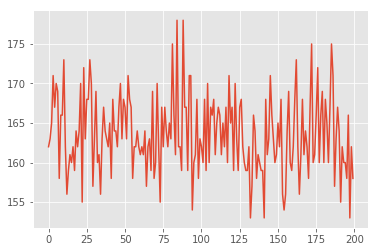

In [10]:
reg_val1 = linear_model.Ridge(alpha = .5)
reg_val1.fit (value_buffer[['s1', 's2','s3','s4']], value_buffer['Q1'])

reg_val2 = linear_model.Ridge (alpha = .5)
reg_val2.fit (value_buffer[['s1', 's2','s3','s4']], value_buffer['Q2'])
returns = newmodel_play(reg_val1, reg_val2)
print(np.mean(returns))

# Plotting performance
plotter(returns)

### Multitask Lasso

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
178.035


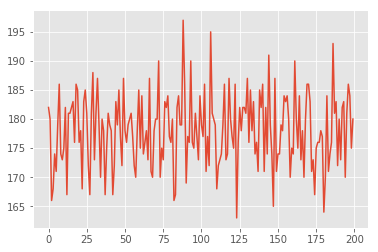

In [11]:
clf = linear_model.MultiTaskLasso(alpha=0.01)
clf.fit(value_buffer[['s1', 's2','s3','s4']], value_buffer[['Q1', 'Q2']])
returns = newmodel_play(clf)
print(np.mean(returns))

# Plotting performance
plotter(returns)

### Multi-output Decision Trees

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
126.63


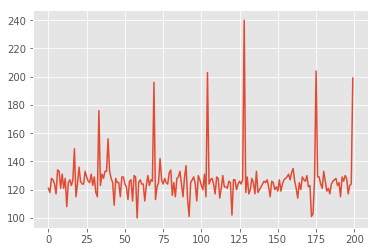

In [12]:
regr = tree.DecisionTreeRegressor(max_depth=28)
regr.fit(value_buffer[['s1', 's2','s3','s4']], value_buffer[['Q1', 'Q2']])
returns = newmodel_play(regr)
print(np.mean(returns))

# Plotting performance
plotter(returns)

In [13]:
# dot_data = tree.export_graphviz(regr, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render("test")